## О задании

Задание состоит из двух разделов:
1. В первом разделе - применение деревьев из **sklearn** для задачи классификации, построение разделяющих поверхностей для различных датасетов, анализ их зависимости от гиперпараметров.
2. Во втором разделе - реализация собственных решающих деревьев, сравнение со стандартной имплиментацией из **sklearn**; тестирование деревьев и сравнение различных подходов к кодированию категориальных признаков.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib.colors import Colormap, ListedColormap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Решающие деревья. Визуализация.

Рассмотрим два простых двумерных датасета, сформированных с помощью `make_moons`, `make_circles` и изучим, как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3, n_redundant=0., ) ]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

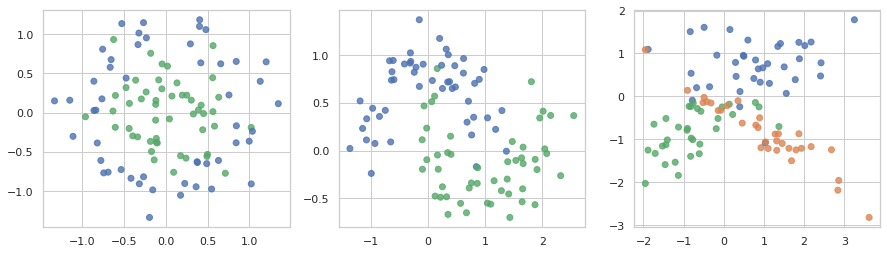

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

### Задание 1

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Вычислите значение **accuracy** на обучающей и тестовой выборках. Оцените степень переобученности деревьев.

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7, edgecolors=np.array(palette)[y], linewidths=2)

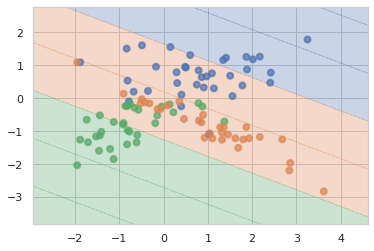

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

### Решение

Точность на обучающей выборке:  1.0
Точность на тестовой выборке:  0.7333333333333333


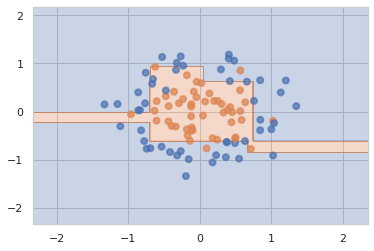

In [7]:
from sklearn.metrics import accuracy_score

X_circles = datasets[0][0] # признаки
y_circles = datasets[0][1] # класс
# разбиение на обучающую  и тестовую выборку
train_data, test_data, train_labels, test_labels = train_test_split(X_circles, y_circles, test_size=0.3, random_state=1) 

circle_tree = DecisionTreeClassifier() # создание модели
circle_tree.fit(train_data, train_labels) # обучение
circle_pred_train = circle_tree.predict(train_data) # прдесказания на обучающей выборке
circle_pred_test = circle_tree.predict(test_data) # предсказания на тестовой выборке

print('Точность на обучающей выборке: ',accuracy_score(circle_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(circle_pred_test, test_labels))

plot_surface(circle_tree, X_circles, y_circles)

Точность на обучающей выборке:  1.0
Точность на тестовой выборке:  0.9666666666666667


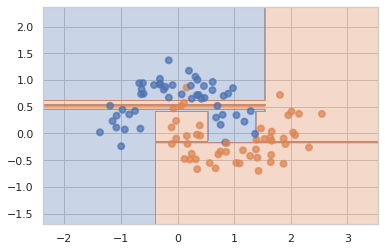

In [8]:
X_moons = datasets[1][0]
y_moons = datasets[1][1]
train_data, test_data, train_labels, test_labels = train_test_split(X_moons, y_moons, test_size=0.3, random_state=1)

moons_tree = DecisionTreeClassifier()
moons_tree.fit(train_data, train_labels)
moons_pred_train = moons_tree.predict(train_data)
moons_pred_test = moons_tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(moons_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(moons_pred_test, test_labels))

plot_surface(moons_tree, X_moons, y_moons)

Точность на обучающей выборке:  1.0
Точность на тестовой выборке:  0.7333333333333333


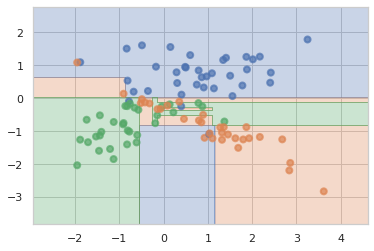

In [9]:
X = datasets[2][0]
y = datasets[2][1]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=1)

tree = DecisionTreeClassifier()
tree.fit(train_data, train_labels)
pred_train = tree.predict(train_data)
pred_test = tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(pred_test, test_labels))

plot_surface(tree, X, y)

**Выводы**: 

* Судя по точности на тестовой выборке, все деревья переучились.

---

### Задание 2

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делать каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (напоминание: итоговое дерево сильно зависит от небольшого изменения обучающей выборки). Проследите, как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

### Решение

Точность на обучающей выборке:  0.9
Точность на тестовой выборке:  0.7


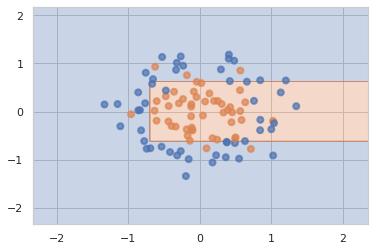

In [10]:
# все то же самое с заданием 1, только меняем параметры модели

train_data, test_data, train_labels, test_labels = train_test_split(X_circles, y_circles, test_size=0.3, random_state=1)

circle_tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5)
circle_tree.fit(train_data, train_labels)
circle_pred_train = circle_tree.predict(train_data)
circle_pred_test = circle_tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(circle_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(circle_pred_test, test_labels))

plot_surface(circle_tree, X_circles, y_circles)

Точность на обучающей выборке:  0.9571428571428572
Точность на тестовой выборке:  0.7333333333333333


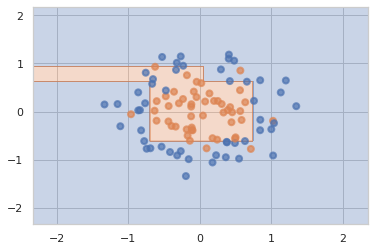

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(X_circles, y_circles, test_size=0.3, random_state=1)

circle_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 3)
circle_tree.fit(train_data, train_labels)
circle_pred_train = circle_tree.predict(train_data)
circle_pred_test = circle_tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(circle_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(circle_pred_test, test_labels))

plot_surface(circle_tree, X_circles, y_circles)

Точность на обучающей выборке:  0.9
Точность на тестовой выборке:  0.8333333333333334


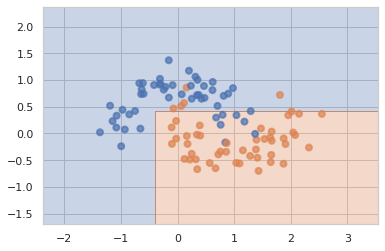

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(X_moons, y_moons, test_size=0.3, random_state=1)

moons_tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5)
moons_tree.fit(train_data, train_labels)
moons_pred_train = moons_tree.predict(train_data)
moons_pred_test = moons_tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(moons_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(moons_pred_test, test_labels))

plot_surface(moons_tree, X_moons, y_moons)

Точность на обучающей выборке:  0.9857142857142858
Точность на тестовой выборке:  0.9666666666666667


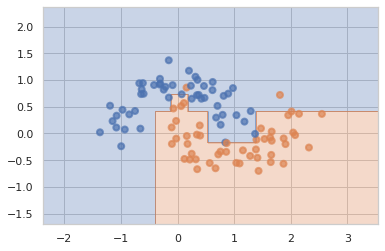

In [13]:
moons_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 3)
moons_tree.fit(train_data, train_labels)
moons_pred_train = moons_tree.predict(train_data)
moons_pred_test = moons_tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(moons_pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(moons_pred_test, test_labels))

plot_surface(moons_tree, X_moons, y_moons)

Точность на обучающей выборке:  0.8571428571428571
Точность на тестовой выборке:  0.9


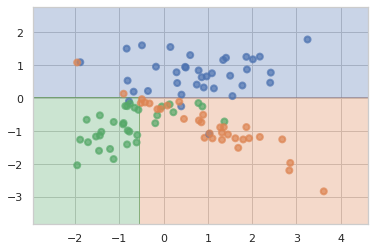

In [14]:
X = datasets[2][0]
y = datasets[2][1]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=1)

tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5)
tree.fit(train_data, train_labels)
pred_train = tree.predict(train_data)
pred_test = tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(pred_test, test_labels))

plot_surface(tree, X, y)

Точность на обучающей выборке:  0.9142857142857143
Точность на тестовой выборке:  0.8666666666666667


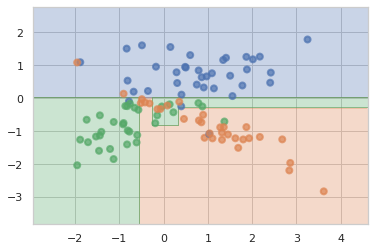

In [15]:
X = datasets[2][0]
y = datasets[2][1]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=1)

tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 3)
tree.fit(train_data, train_labels)
pred_train = tree.predict(train_data)
pred_test = tree.predict(test_data)

print('Точность на обучающей выборке: ',accuracy_score(pred_train, train_labels))
print('Точность на тестовой выборке: ',accuracy_score(pred_test, test_labels))

plot_surface(tree, X, y)

**Выводы**:

* Чем больше максимальная глубина дерева и меньше минимальное число элементов в листе, тем на разделяющей поверхности больше небольших разделений.
* Дерево переобучается, т.к. появляется больше возможностей разделять выборку.
* Нужно подбирать оптимальные значения `max_depth` и `min_samples_leaf` для наилучшей обобщающей способности модели, у каждой выборки эти числа индивидуальные.

---

# 2. Решающие деревья своими руками

В этой части нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

### Задание 3

Реализуйте функцию `find_best_split` для получения оптимального разбиения по заданному признаку.

### Решение

In [16]:
def dict_classes(values): 
    classes = {}
    for value in values:
        if value not in classes:
            classes[value] = 0
        classes[value] += 1
    return classes

def gini(labels): 
    classes = dict_classes(labels)
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity 

def gain(true_values, false_values, values): 
    p = float(true_values.shape[0]) / (true_values.shape[0] + false_values.shape[0])
    return gini(values) - p * gini(true_values) - (1 - p)*gini(false_values)

def split(data, values, column_index, t):

    left = np.where(data[:, column_index] <= t)  # находим индексы элементов который пойдут в левую ветку
    right = np.where(data[:, column_index] > t) # индексы элементов в правую ветку
        
    true_data = data[left] # признаки элементов левой ветки
    false_data = data[right] # признаки элементов правой ветки

    true_values = values[left] # значеняи классов левой ветки
    false_values = values[right] # значения классов правой ветки
        
    return true_data, false_data, true_values, false_values

def find_best_split(data, values, index): # выбор наилучшего разбиения
    best_gain = 0 # лучший прирост информативности
    best_t = None # лучшее значение порога

    t_values = np.unique(data[:, index]) # создаем список уникальных значений признака
    for t in t_values: # перебор по значениям признака
        true_data, false_data, true_values, false_values = split(data, values, index, t) # разбиваем выборку по t порогу
        current_gain = gain(true_values, false_values, values) # считаем прирост информативности
        if current_gain > best_gain:  # если прирос информативности больше текущего максимального, то присваиваем
            best_gain, best_t = current_gain, t
    return best_gain, best_t

find_best_split(X, y, 1)

(0.27713153153153147, -0.10371376377012287)

### Задание 4
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

### Решение

In [17]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/students.csv')
df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


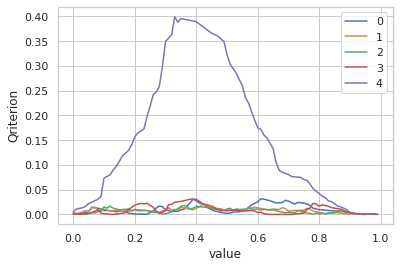

In [19]:
data = df.iloc[:,:-1].to_numpy()
labels = df.iloc[:,-1].to_numpy()

for index in range(data.shape[1]): # перебор индексов признаков
    gain_list = [] # список со значениями прироста информативности
    t_values = np.unique(data[:, index]) # уникальные значения признаков
    for t in t_values: # перебор по уникальным значениям признака
        true_data, false_data, true_values, false_values = split(data, labels, index, t) # разбиение на ветки
        gain(true_values, false_values, list(labels)) # подсчет прироста информативности
        gain_list.append(gain(true_values, false_values, labels)) # добавления прироста в список
    plt.plot(t_values, gain_list) # рисуем кривую, признаки по оси Х, прирост по У
plt.xlabel("vаlue")
plt.ylabel("Qriterion")
plt.legend(range(5));

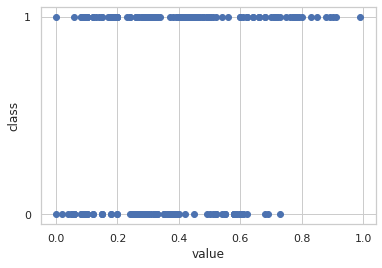

In [20]:
plt.scatter(data[:, 0], labels)  # рисуем график, по Х значения признака, по У класс
plt.xlabel("value")
plt.ylabel("class")
plt.yticks([0,1]);

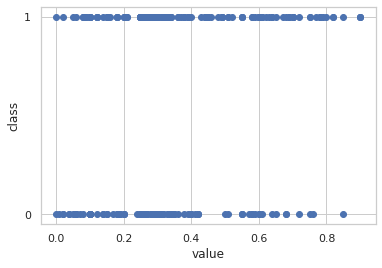

In [21]:
plt.scatter(data[:, 1], labels)
plt.xlabel("value")
plt.ylabel("class")
plt.yticks([0,1]);

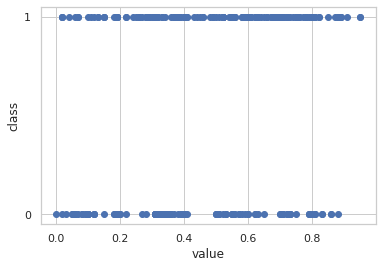

In [22]:
plt.scatter(data[:, 2], labels)
plt.xlabel("value")
plt.ylabel("class")
plt.yticks([0,1]);

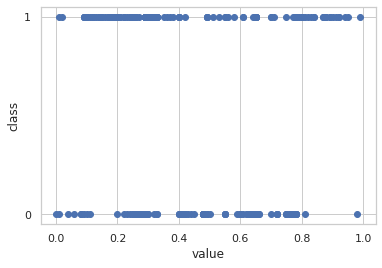

In [23]:
plt.scatter(data[:, 3], labels)
plt.xlabel("value")
plt.ylabel("class")
plt.yticks([0,1]);

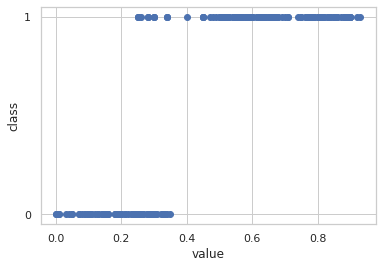

In [24]:
plt.scatter(data[:, 4], labels)
plt.xlabel("value")
plt.ylabel("class")
plt.yticks([0,1]);

### Задание 5

Исходя из кривых значений критерия Джини, сделайте вывод: по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как можно охарактеризовать вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Решение

Исходя из кривых критерия, деление выборки на два поддерева нужно производить по последнему признаку. Это отчетливо видно и на scatter-графиках. Признаки, кривые которых образуют фигуру с самой большое площадью, наиболее подходят для разбиения на два поддерева, т.к. чем выше проходит кривая, тем больше критерий информативности.

### Задание 6 (дополнительно)

Выполните собственную реализацию класса DecisionTree для работы с решающими деревьями.

Выбор лучшего разбиения необходимо производить по критерию Джини. 

Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. 

Ответ в листе: наиболее часто встречающийся класс в листе. 

### Решение

In [25]:
# Реализуем класс узла
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, values):
        self.data = data  # признаки
        self.values = values # классы
        self.prediction = self.predict() # предсказание узла

    def predict(self):
        # сформируем словарь "класс: количество объектов"
        values = {}
        for value in self.values:
            if value not in values:
                values[value] = 0
            values[value] += 1
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его 
        prediction = max(values, key=values.get)
        return prediction    

class DecisionTree:

    def __init__(self):
        self.tree = None

    def gain(self, true_values, false_values, values):
        p = float(true_values.shape[0]) / (true_values.shape[0] + false_values.shape[0])
        return gini(values) - p * gini(true_values) - (1 - p)*gini(false_values)

    def split(self, data, values, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_values = values[left]
        false_values = values[right]

        return true_data, false_data, true_values, false_values

    def find_best_split(self, data, values):
        best_gain = 0
        best_t = None
        best_index = None
        n_features = data.shape[1]
        for index in range(n_features):
            t_values = np.unique(data[:, index])
            for t in t_values:
                true_data, false_data, true_values, false_values = self.split(data, values, index, t)
                current_gain = self.gain(true_values, false_values, values)
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index
        return best_gain, best_t, best_index

      
    def fit(self, data, values, depth = 0): # обучение

        gain, t, index = self.find_best_split(data, values)
        if (gain == 0): # если прироста информативности нет, значит все объекты в листе 
        # относятся к одному классу или ни по одному признаку нельзя разбить выборку
            self.tree = Leaf(data, values) # присваем полю узел
            return self.tree # завершаем чать рекурси так как дошли до листа,
        # Рекурсивно строим два поддерева
        true_data, false_data, true_values, false_values = self.split(data, values, index, t)
        true_branch = self.fit(true_data, true_values, depth = depth + 1)
        false_branch = self.fit(false_data, false_values, depth = depth + 1)
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.tree = Node(index, t, true_branch, false_branch)
        return self.tree # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

    def predict(self, data): # метод для предсказаний 
        classes = [] # создаем список с предсказанными классами
        for obj in data: # перебор по признаким 
            prediction = self.classify_object(obj, self.tree)  # см метод
            classes.append(prediction) # добавляем прдесказание в список
        return classes

    def classify_object(self, obj, node):
        if isinstance(node, Leaf): # проверям является ли узел листом
            answer = node.prediction # присваиваем предсказанный класс
            return answer # заканчиваем рекурсию
        if obj[node.index] <= node.t: # смотрим по какой ветке идти
            return self.classify_object(obj, node.true_branch) # вызывам эту же функцию со следующим узлом
        else:
            return self.classify_object(obj, node.false_branch)


    def dict_classes(self, values):
        classes = {}
        for value in values:
            if value not in classes:
                classes[value] = 0
            classes[value] += 1
        return classes

    def gini(self, labels):
        classes = self.dict_classes(labels)
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity

### Задание 7 (для тех, кто выполнил задание 6)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous). Оценка качества будет выполняться с помощью **accuracy**, поэтому не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите значение **accuracy**.

Должно получиться значение **accuracy**, равное единице (или очень близкое к единице), и не очень глубокое дерево.

### Решение

In [26]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/agaricus-lepiota.data')
df = df.to_numpy()
le = LabelEncoder()
# Преобразуем признаки в натуральные числа
for i in range(df.shape[1]): # перебор по признакам
    le.fit(df[:,i])
    df[:,i] = le.transform(df[:,i])  # преобразуем признак

In [27]:
X = df[:, 1:]
y = df[:, 0]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.5, random_state=1)

tree = DecisionTree()
tree.fit(train_data, train_labels)
pred = tree.predict(test_data)

print('Точность на тестовой выборке: ',accuracy_score(pred, list(test_labels)))

Точность на тестовой выборке:  1.0


### Задание 8 (для тех, кто выполнил задания 6 и 7)
Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце).

### Решение

In [28]:
import numpy as np
import pandas as pd

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()

    def predict(self):
        values = {}
        for value in self.values:
            if value not in values:
                values[value] = 0
            values[value] += 1
        prediction = max(values, key=values.get)
        return prediction  

class Tree:

    def __init__(self, max_depth, min_samples_leaf, min_samples_split):
        self.max_depth = max_depth # макимальная глубина
        self.min_samples_split = min_samples_split # минимальное количество объектов в листе, при котором можно делать разбиение
        self.min_samples_leaf = min_samples_leaf # минимальное количество объектов в листе 
        self.tree = None

    def gain(self, true_values, false_values, values):
        p = float(true_values.shape[0]) / (true_values.shape[0] + false_values.shape[0])
        return gini(values) - p * gini(true_values) - (1 - p)*gini(false_values)

    def split(self, data, values, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_values = values[left]
        false_values = values[right]

        return true_data, false_data, true_values, false_values

    def find_best_split(self, data, values):
        best_gain = 0
        best_t = None
        best_index = None
        if data.shape[0] < self.min_samples_split: # если количество объектов в листе меньше минимального числа, при котором можно разбивать
            return best_gain, best_t, best_index # то присваимваем нулево прирост, затем узел станет листом
        n_features = data.shape[1]
        for index in range(n_features):
            t_values = np.unique(data[:, index])
            for t in t_values:
                true_data, false_data, true_values, false_values = self.split(data, values, index, t)
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf: # проверям чтобы количество объектов в листе было не меньше минимального
                    continue # если меньше, то не учитываем это разбиение и идем дальше
                current_gain = self.gain(true_values, false_values, values)
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index
        return best_gain, best_t, best_index

      
    def fit(self, data, values, depth = 0): # изначально глубина равна 0

        gain, t, index = self.find_best_split(data, values)
        if (gain == 0) or (depth  == self.max_depth): # проверям глубину дерева
            self.tree = Leaf(data, values)
            return self.tree
        true_data, false_data, true_values, false_values = self.split(data, values, index, t)
        true_branch = self.fit(true_data, true_values, depth = depth + 1) # прибавляем глубину
        false_branch = self.fit(false_data, false_values, depth = depth + 1)
        self.tree = Node(index, t, true_branch, false_branch)
        return self.tree

    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

    def dict_classes(self, values):
        classes = {}
        for value in values:
            if value not in classes:
                classes[value] = 0
                classes[value] += 1
        return classes

    def gini(self, labels):
        classes = self.dict_classes(labels)
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity 

In [29]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/tic-tac-toe.data')
df = df.to_numpy()
le = LabelEncoder()
for i in range(df.shape[1]):
    le.fit(df[:,i])
    df[:,i] = le.transform(df[:,i])

In [30]:
X = df[:,:-1]
y = df[:, -1]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=1)

Text(0.5, 1.0, 'min_samples_leaf = 5, min_samples_split = 5')

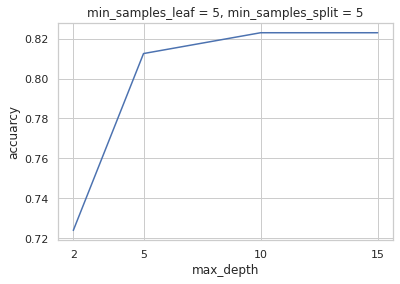

In [31]:
max_depth = [2,5,10,15] # заначения максимальной глубины 
score = [] # список значений приростов при разных максимальных глубинах

for i in max_depth: # перебор по значениям
    tree = Tree(i, 5, 5)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels))) # добавляем пирост

plt.plot(max_depth, score) # рисуем график
plt.xlabel("max_depth")
plt.ylabel("accuarcy")
plt.xticks(max_depth)
plt.title("min_samples_leaf = 5, min_samples_split = 5")

Text(0.5, 1.0, 'min_samples_leaf = 3, min_samples_split = 10')

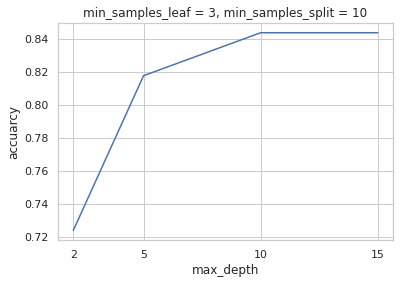

In [32]:
max_depth = [2,5,10,15]
score = []

for i in max_depth:
    tree = Tree(i, 3, 10)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels)))

plt.plot(max_depth, score)
plt.xlabel("max_depth")
plt.ylabel("accuarcy")
plt.xticks(max_depth)
plt.title("min_samples_leaf = 3, min_samples_split = 10")

Text(0.5, 1.0, 'max_depth = 10, min_samples_split = 2')

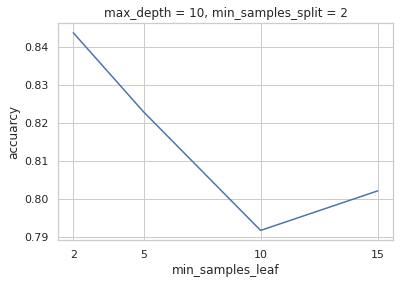

In [33]:
min_samples_leaf = [2,5,10,15]
score = []

for i in min_samples_leaf:
    tree = Tree(10, i, 2)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels)))

plt.plot(min_samples_leaf, score)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuarcy")
plt.xticks(max_depth)
plt.title("max_depth = 10, min_samples_split = 2")

Text(0.5, 1.0, 'max_depth = 5, min_samples_split = 2')

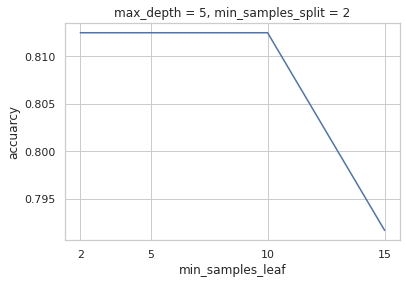

In [34]:
min_samples_leaf = [2,5,10,15]
score = []

for i in min_samples_leaf:
    tree = Tree(5, i, 2)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels)))

plt.plot(min_samples_leaf, score)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuarcy")
plt.xticks(max_depth)
plt.title("max_depth = 5, min_samples_split = 2")

Text(0.5, 1.0, 'max_depth = 10, min_samples_leaf = 2')

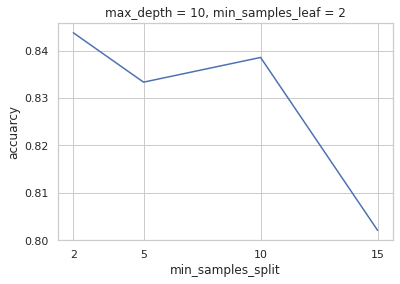

In [35]:
min_samples_split = [2,5,10,15]
score = []

for i in min_samples_leaf:
    tree = Tree(10, 2, i)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels)))

plt.plot(max_depth, score)
plt.xlabel("min_samples_split")
plt.ylabel("accuarcy")
plt.xticks(min_samples_split)
plt.title("max_depth = 10, min_samples_leaf = 2")

Text(0.5, 1.0, 'max_depth = 5, min_samples_leaf = 2')

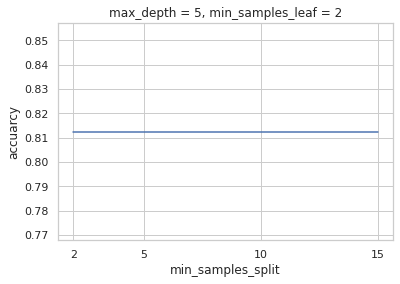

In [36]:
min_samples_split = [2,5,10,15]
score = []

for i in min_samples_leaf:
    tree = Tree(5, 2, i)
    tree.fit(train_data, train_labels)
    pred = tree.predict(test_data)
    score.append(accuracy_score(pred, list(test_labels)))

plt.plot(max_depth, score)
plt.xlabel("min_samples_split")
plt.ylabel("accuarcy")
plt.xticks(min_samples_split)
plt.title("max_depth = 5, min_samples_leaf = 2")